In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from helper_functions import *
from xgboost import XGBClassifier, plot_importance
from models import *
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import os
import pickle


In [166]:
# Define the directory where the pickle files are stored
load_directory = 'Sets'

# Function to load an object from a pickle file
def load_from_pickle(file_name):
    file_path = os.path.join(load_directory, file_name)
    with open(file_path, 'rb') as file:
        return pickle.load(file)

# Load each DataFrame and Series
df_tot = load_from_pickle('df_tot.pkl')
y_train_h = load_from_pickle('y_train_h.pkl')
y_train_b = load_from_pickle('y_train_b.pkl')
y_test_h = load_from_pickle('y_test_h.pkl')
y_test_b = load_from_pickle('y_test_b.pkl')
X_test = load_from_pickle('X_test.pkl')
X_train = load_from_pickle('X_train.pkl')
X_train_h = load_from_pickle('X_train_h.pkl')

# Optionally, load the dictionary containing the lengths of JIC codes
dict_jic_lengths = load_from_pickle('dict_jic_lengths.pkl')

print("All files have been loaded successfully from the folder:", load_directory)


All files have been loaded successfully from the folder: Sets


In [167]:
lgbm_model, binary_params = train_lgbm_binary_class_model(X_train, y_train_b)
y_pred = lgbm_model.predict(X_test)
accuracy_nr_boolean = accuracy_score(y_test_b, y_pred)
print(f"Accuracy for nr_boolean: {accuracy_nr_boolean:.4f}")


Accuracy for nr_boolean: 0.9284


              precision    recall  f1-score   support

           0       0.94      0.99      0.96    125816
           1       0.78      0.39      0.52     13867

    accuracy                           0.93    139683
   macro avg       0.86      0.69      0.74    139683
weighted avg       0.92      0.93      0.92    139683



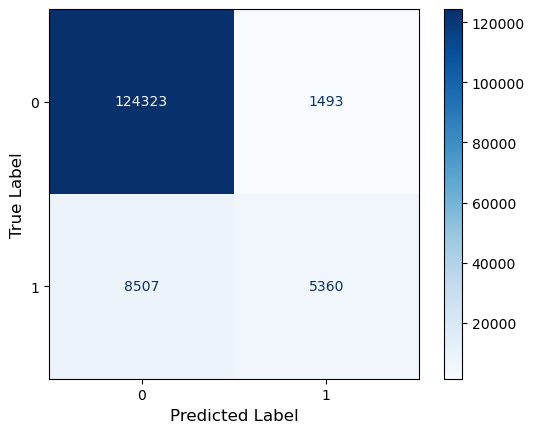

In [168]:
# Generate the classification report
report = classification_report(y_test_b, y_pred, target_names=[str(label) for label in sorted(y_test_b.unique())])
# Print the classification report
print(report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_b, y_pred)
# Get the unique labels from the test set (this should match the classes in y_test_n['nrtask'])
unique_labels = sorted(y_test_b.unique())

# Display the confusion matrix with axis labels
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues)  # You can change the color map if desired

# Add axis labels
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

In [169]:
# To save the model
filename= 'LGBM_binary.pkl'
with open(f'Models/{filename}', 'wb') as file:
    pickle.dump(lgbm_model, file)

In [170]:
# X_train_h=X_train_h[X_train_h['nr_boolean']==1]
# y_train_h=y_train_h[y_train_h!=0]

# y_train_h


In [171]:
# Assuming y_pred is a NumPy array or a list of predictions
y_pred_series = pd.Series(y_pred, name='nr_boolean')
X_test_h = X_test.copy()
#X_test_h['nr_boolean'] = y_pred_series.values

#hours_model, hours_params = train_lgbm_regress_model(X_train_h, y_train_h)

hours_model, hours_params = train_lgbm_regress_model(X_train, y_train_h)
print(hours_params)
y_pred_h = hours_model.predict(X_test_h)
y_pred_h[y_pred_series == 0] = 0
y_pred_h[y_pred_h < 0] = 0

mae = mean_absolute_error(y_test_h, y_pred_h)
mae_0 = mean_absolute_error(y_test_h, np.zeros(shape=y_test_h.shape))
mae_mean = mean_absolute_error(y_test_h, np.mean(y_test_h)*np.ones(shape=y_test_h.shape))
print(f'MAE = {round(mae, 3)}')
print(f'MAE of 0 = {round(mae_0, 3)}')
print(f'MAE of mean = {round(mae_mean, 3)}')

{'n_estimators': 50, 'max_depth': 12, 'learning_rate': 0.1, 'subsample': 1, 'colsample_bytree': 1, 'num_leaves': 64}
MAE = 0.231
MAE of 0 = 0.34
MAE of mean = 0.616


In [172]:
# To save the model
filename= 'LGBM_regress.pkl'
with open(f'Models/{filename}', 'wb') as file:
    pickle.dump(hours_model, file)

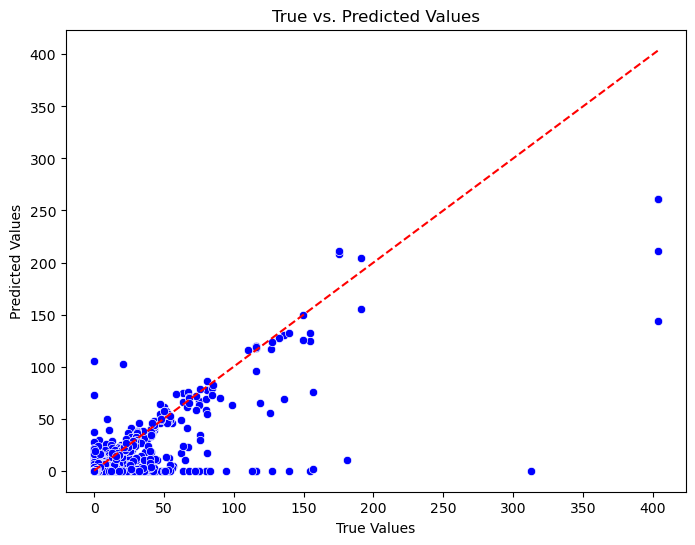

In [173]:
# Plotting
plt.figure(figsize=(8, 6))  # Set the figure size for better visibility
sns.scatterplot(x=y_test_h, y=y_pred_h, color='blue')  # Scatter plot of y_true vs y_pred

# Line of perfect prediction
plt.plot([y_test_h.min(), y_test_h.max()], [y_test_h.min(), y_test_h.max()], 'r--')  # Red dashed line

# Adding plot labels and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')

# Show the plot
plt.show()

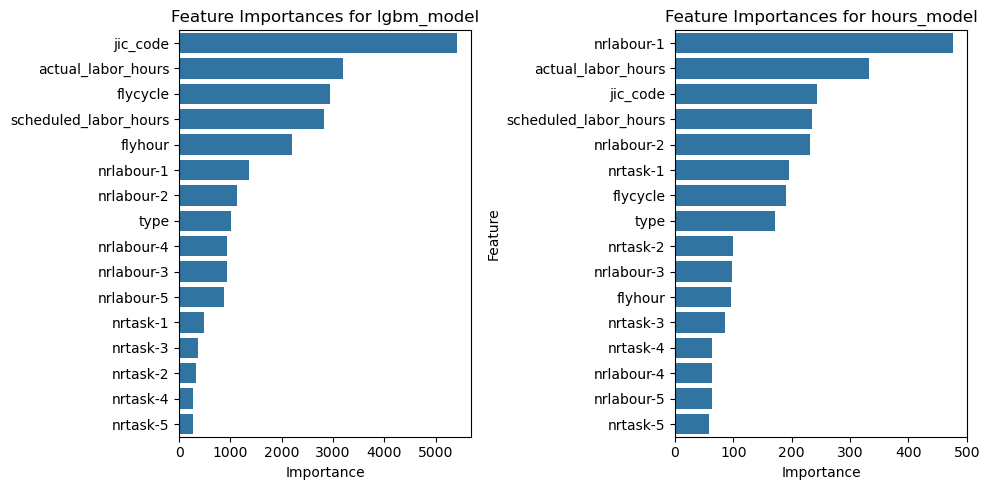

In [174]:
# Assuming 'hours_model' and 'lgbm_model' are both trained
importances_hours = hours_model.feature_importances_
importances_lgbm = lgbm_model.feature_importances_

# Assume X_train_h and X_train_l are the feature DataFrames for both models
feature_names_hours = X_train.columns
feature_names_lgbm = X_train.columns  # Assuming similar feature sets for simplicity

feature_imports_hours = pd.DataFrame({'Feature': feature_names_hours, 'Importance': importances_hours})
feature_imports_lgbm = pd.DataFrame({'Feature': feature_names_lgbm, 'Importance': importances_lgbm})

# Sorting the importances
feature_imports_hours = feature_imports_hours.sort_values(by='Importance', ascending=False)
feature_imports_lgbm = feature_imports_lgbm.sort_values(by='Importance', ascending=False)

# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)  # sharey ensures both plots share the same y-axis

# Plot for hours_model
sns.barplot(x='Importance', y='Feature', data=feature_imports_hours, ax=axes[1])
axes[1].set_title('Feature Importances for hours_model')
axes[1].set_xlabel('Importance')
axes[1].set_ylabel('Feature')

# Plot for lgbm_model
sns.barplot(x='Importance', y='Feature', data=feature_imports_lgbm, ax=axes[0])
axes[0].set_title('Feature Importances for lgbm_model')
axes[0].set_xlabel('Importance')
axes[0].set_ylabel('')

# Display the plot
plt.tight_layout()
plt.show()

In [175]:
df = pd.DataFrame({
    'True Values': y_test_h,
    'Predicted Values': y_pred_h
})

# Create a scatter plot
fig = px.scatter(df, x='True Values', y='Predicted Values', title='True vs. Predicted Values',
                 labels={'x': 'True Values', 'y': 'Predicted Values'}, color_discrete_sequence=['blue'])

# Add line of perfect prediction
fig.add_shape(
    type='line', line=dict(dash='dash', color='red'),
    x0=y_test_h.min(), y0=y_test_h.min(), x1=y_test_h.max(), y1=y_test_h.max()
)

# Show the plot
fig.show()

/var/folders/gm/pvnntq692jd5ng0rtk5l0z9m0000gn/T/ipykernel_42439/579745976.py:30: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/gm/pvnntq692jd5ng0rtk5l0z9m0000gn/T/ipykernel_42439/579745976.py:31: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/gm/pvnntq692jd5ng0rtk5l0z9m0000gn/T/ipykernel_42439/579745976.py:32: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



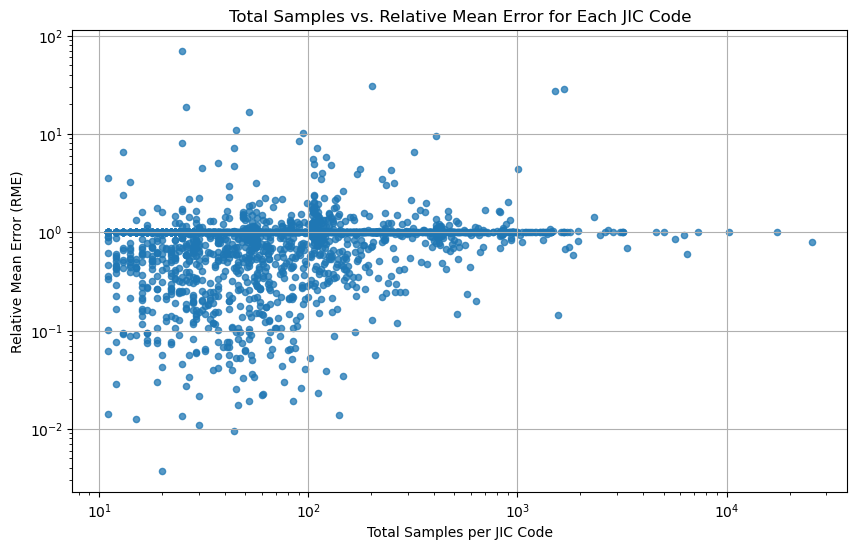

<Figure size 1200x800 with 0 Axes>

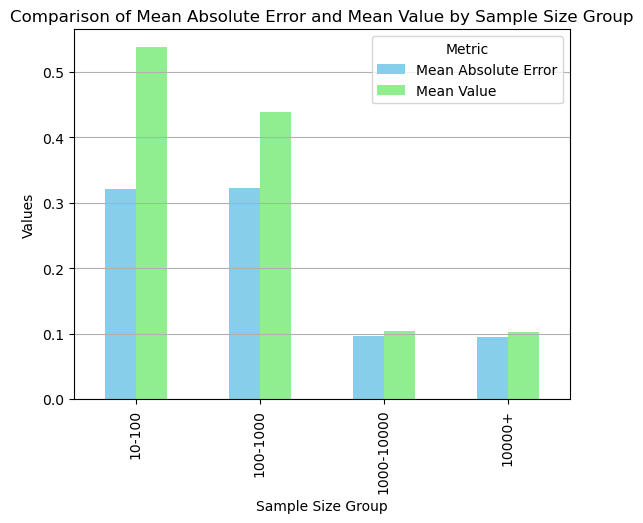

In [176]:
# Assuming y_pred_h, y_test_h, and X_test_h are already defined

# Add the total samples count for each jic_code to X_test_h
X_test_h['total_samples'] = X_test_h['jic_code'].map(dict_jic_lengths)

# Calculate absolute deviations and actual values deviation
X_test_h['abs_deviation'] = abs(y_pred_h - y_test_h)
X_test_h['zero_deviation'] = abs(y_test_h)
X_test_h['prediction'] = y_pred_h

#X_test_h = X_test_h[X_test_h['prediction'] != 0]

# Group by 'jic_code' to calculate mean absolute deviation and mean actual deviation, using the 'total_samples' for sizing
grouped = X_test_h.groupby('jic_code').agg(
    MAD=('abs_deviation', 'mean'),
    MZD=('zero_deviation', 'mean'),
    MP=('prediction', 'mean'),
    total_samples=('total_samples', 'first')  # 'first' because all entries per group are the same
)

# Calculate the Relative Mean Error (RME) as MAD divided by MZD
grouped['RME'] = grouped['MAD'] / grouped['MZD']

# Create bins for total samples
bins = [10, 100, 1000, 10000, np.inf]  # Adjust as needed
labels = ['10-100', '100-1000', '1000-10000', '10000+']
grouped['sample_bin'] = pd.cut(grouped['total_samples'], bins=bins, labels=labels, right=False)

# Calculate mean RME for each bin
bin_grouped = grouped.groupby('sample_bin')['MAD'].mean()
bin_grouped_zero = grouped.groupby('sample_bin')['MZD'].mean()
bin_grouped_pred = grouped.groupby('sample_bin')['MP'].mean()

# Scatter Plot for RME vs Total Samples
plt.figure(figsize=(10, 6))
plt.scatter(grouped['total_samples'], grouped['RME'], s=20, alpha=0.75)
plt.title('Total Samples vs. Relative Mean Error for Each JIC Code')
plt.xlabel('Total Samples per JIC Code')
plt.ylabel('Relative Mean Error (RME)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

# Create a new DataFrame to hold the data for plotting
combined_data = pd.DataFrame({
    'Mean Absolute Error': bin_grouped,
    'Mean Value': bin_grouped_zero,
})

# Bar Chart for Combined Metrics by Sample Size Group
plt.figure(figsize=(12, 8))
combined_data.plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Comparison of Mean Absolute Error and Mean Value by Sample Size Group')
plt.xlabel('Sample Size Group')
plt.ylabel('Values')
plt.grid(axis='y')
plt.legend(title='Metric')
plt.show()



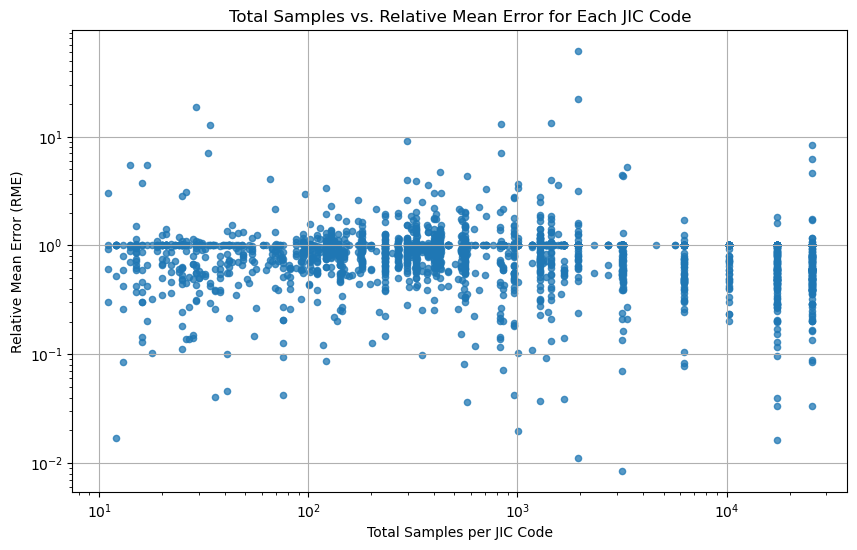

<Figure size 1200x800 with 0 Axes>

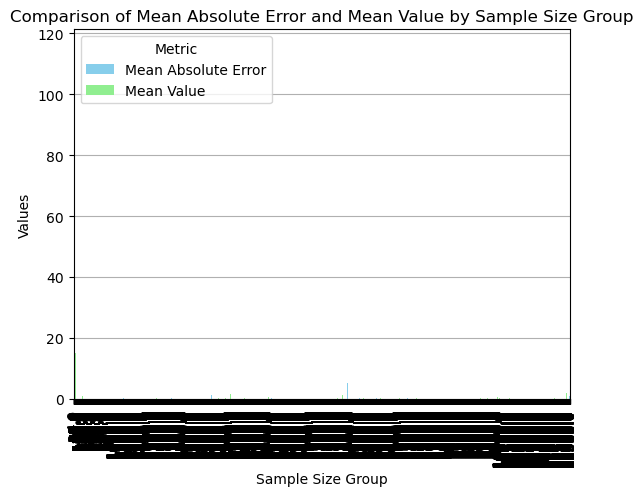

In [ ]:
# Assuming y_pred_h, y_test_h, and X_test_h are already defined

# Add the total samples count for each jic_code to X_test_h
X_test_h['total_samples'] = X_test_h['jic_code'].map(dict_jic_lengths)

# Calculate absolute deviations and actual values deviation
X_test_h['abs_deviation'] = abs(y_pred_h - y_test_h)
X_test_h['zero_deviation'] = abs(y_test_h)
X_test_h['prediction'] = y_pred_h

# Group by 'jic_code' to calculate mean absolute deviation and mean actual deviation, using the 'total_samples' for sizing
grouped = X_test_h.groupby('flycycle').agg(
    MAD=('abs_deviation', 'mean'),
    MZD=('zero_deviation', 'mean'),
    MP=('prediction', 'mean'),
    
    total_samples=('total_samples', 'first')  # 'first' because all entries per group are the same
)

# Calculate the Relative Mean Error (RME) as MAD divided by MZD
grouped['RME'] = grouped['MAD'] / grouped['MZD']

# Calculate mean RME for each bin
bin_grouped = grouped['MAD']
bin_grouped_zero = grouped['MZD']
bin_grouped_pred = grouped['MP']

# Scatter Plot for RME vs Total Samples
plt.figure(figsize=(10, 6))
plt.scatter(grouped['total_samples'], grouped['RME'], s=20, alpha=0.75)
plt.title('Total Samples vs. Relative Mean Error for Each JIC Code')
plt.xlabel('Total Samples per JIC Code')
plt.ylabel('Relative Mean Error (RME)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

# Create a new DataFrame to hold the data for plotting
combined_data = pd.DataFrame({
    'Mean Absolute Error': bin_grouped,
    'Mean Value': bin_grouped_zero,
})

# Bar Chart for Combined Metrics by Sample Size Group
plt.figure(figsize=(12, 8))
combined_data.plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Comparison of Mean Absolute Error and Mean Value by Sample Size Group')
plt.xlabel('Sample Size Group')
plt.ylabel('Values')
plt.grid(axis='y')
plt.legend(title='Metric')
plt.show()



In [ ]:
X_test_h

nrlabour-2  flycycle  nrlabour-4  nrlabour-5  flyhour  nrtask-1  \
0              0.0    9219.0         0.0         0.0  80037.0       0.0   
1              0.0    9326.0         0.0         0.0  76528.0       0.0   
2              0.0    8877.0         0.0         0.0  75605.0       0.0   
3              0.0    9219.0         0.0         0.0  80037.0       0.0   
4              0.0    9905.0         0.0         0.0  85214.0       0.0   
...            ...       ...         ...         ...      ...       ...   
139678         0.0   10747.0         0.0         0.0  92430.0       0.0   
139679         0.0    7700.0         0.0         0.0  66111.0       0.0   
139680         0.0   10381.0         0.0         0.0  88667.0       0.0   
139681         0.0    8158.0         0.0         0.0  69992.0       0.0   
139682         0.0     936.0         0.0         0.0   7440.0       0.0   

        nrtask-4  jic_code  nrtask-3  nrtask-2  nrlabour-1  \
0            0.0         0       0.0       0.0         0.0   
1            0.0         0       0.0       0.0         0.0   
2            0.0         0       0.0       0.0         0.0   
3            0.0         0       0.0       0.0         0.0   
4            0.0         0       0.0       0.0         0.0   
...          ...       ...       ...       ...         ...   
139678       0.0      5600       0.0       0.0         0.0   
139679       0.0      5600       0.0       0.0         0.0   
139680       0.0      5600       0.0       0.0         0.0   
139681       0.0      5600       0.0       0.0         0.0   
139682       0.0      5600       0.0       0.0         0.0   

        actual_labor_hours  nrlabour-3  scheduled_labor_hours  nrtask-5  type  \
0                  0.10000         0.0                    2.0       0.0     0   
1                  2.00000         0.0                    2.0       0.0     0   
2                  0.00000         0.0                    0.0       0.0     0   
3                  2.00000         0.0                    2.0       0.0     0   
4                  2.00000         0.0                    2.0       0.0     0   
...                    ...         ...                    ...       ...   ...   
139678             0.03334         0.0                    0.0       0.0     0   
139679             2.50000         0.0                    0.0       0.0     0   
139680             0.50000         0.0                    0.0       0.0     0   
139681             0.50000         0.0                    0.0       0.0     0   
139682             0.50000         0.0                    0.5       0.0     0   

        total_samples  abs_deviation  zero_deviation  prediction  
0                  22            0.0             0.0         0.0  
1                  22            0.0             0.0         0.0  
2                  22            0.0             0.0         0.0  
3                  22            0.0             0.0         0.0  
4                  22            0.0             0.0         0.0  
...               ...            ...             ...         ...  
139678             36            0.0             0.0         0.0  
139679             36            1.0             1.0         0.0  
139680             36            0.0             0.0         0.0  
139681             36            0.0             0.0         0.0  
139682             36            0.0             0.0         0.0  

[139683 rows x 20 columns]